<a href="https://colab.research.google.com/github/alice202122/2competitionDL/blob/main/prova_attention_modellodiverso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [27]:
dataset = pd.read_csv('Training.csv').dropna().astype(np.float32)


print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.976980,4.33494,10.672820,1.76692,3.22440,51.681461,3.65434
1,8.078239,4.44616,10.561601,1.70716,3.32566,51.563599,3.47672
2,8.028440,4.22372,10.561601,1.64906,3.17460,50.863079,3.47672
3,8.028440,4.22372,10.561601,1.70716,3.17460,45.841579,3.47672
4,7.875721,4.44616,10.450379,1.70716,3.27586,47.126423,3.47672


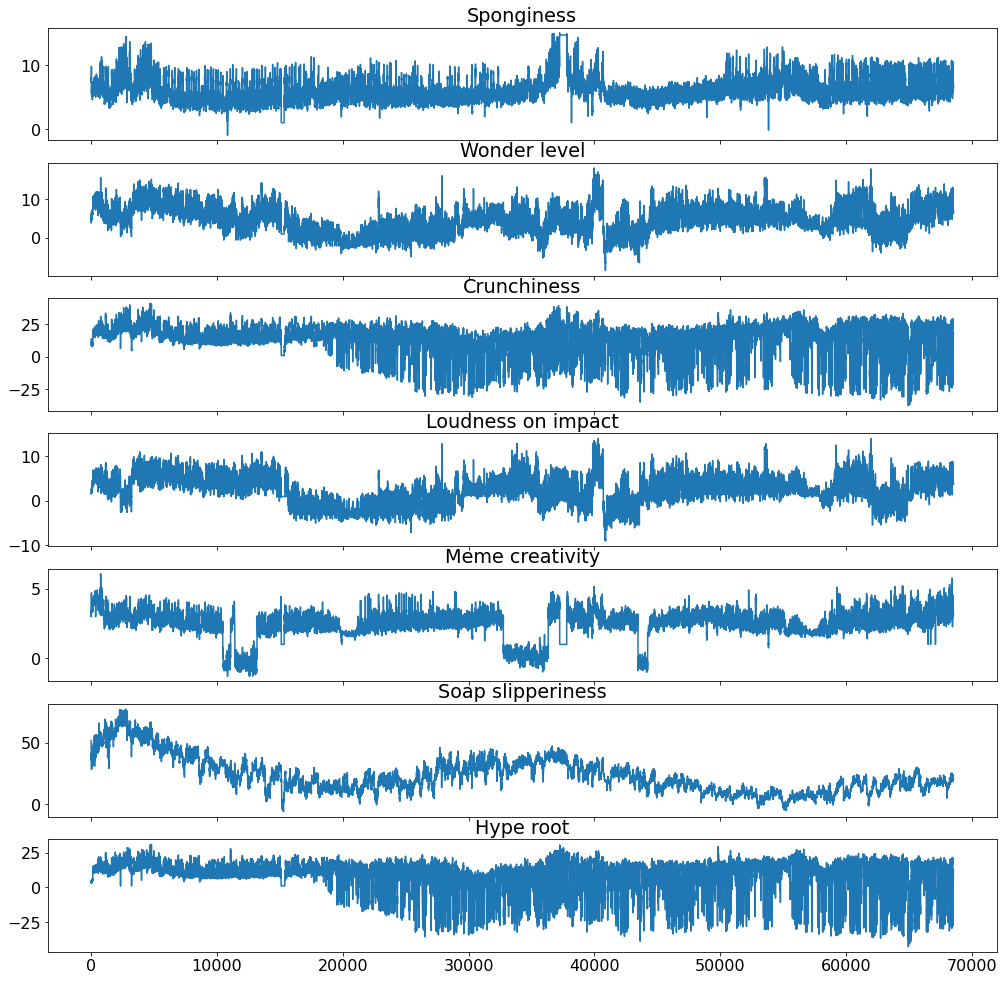

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(65528, 7) (3000, 7)


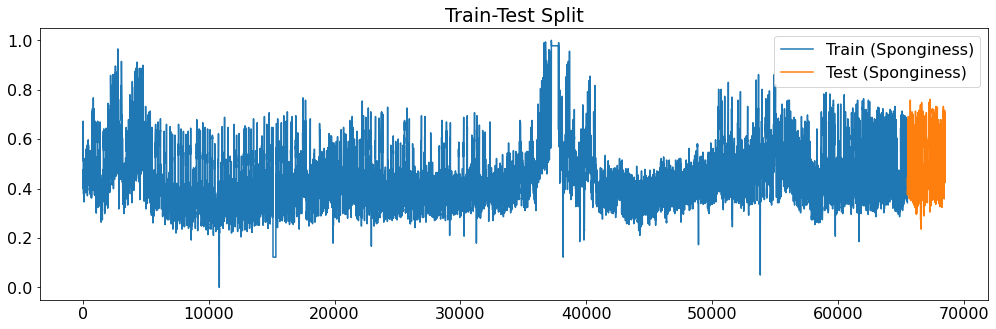

In [41]:
test_size = 3000 #random number
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [45]:
def build_sequences(df, target_labels=['Sponginess']):
    window=200
    stride=10
    telescope=864
    assert window % stride == 0
    dataset = [] #we create 2 lists
    labels = []
    temp_df = df.copy().values #our x variable
    temp_label = df[target_labels].copy().values #the label can be one singole column, a subset of the entrie set of columns or all the columns
    padding_len = len(df)%window

    if(padding_len != 0): 
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx])
        labels.append(temp_label[idx])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [46]:
target_labels= dataset.columns
X_train, y_train = build_sequences(X_train_raw, target_labels)
X_test, y_test = build_sequences(X_test_raw, target_labels)
#we apply thenext functions to both test and train
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6454, 7), (6454, 7), (194, 7), (194, 7))

In [48]:
maxlen = 200
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


In [49]:
X_train.shape

(6454, 200)

In [91]:
y_train.shape

(6454, 7)

In [83]:
model = Sequential()
model.add(Embedding(1000, 64, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['mae']) 
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 64)           64000     
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
81/81 [==============================] - 28s 341ms/step - loss: 0.0309 - mae: 0.1460 - val_loss: 0.0379 - val_mae: 0.1559 - lr: 2.5000e-04
Epoch 2/200
81/81 [==============================] - 26s 326ms/step - loss: 0.0309 - mae: 0.1459 - val_loss: 0.0379 - val_mae: 0.1559 - lr: 2.5000e-04
Epoch 3/200
81/81 [==============================] - 26s 322ms/step - loss: 0.0309 - mae: 0.1460 - val_loss: 0.0381 - val_mae: 0.1562 - lr: 2.5000e-04
Epoch 4/200
81/81 [==============================] - 27s 333ms/step - loss: 0.0309 - mae: 0.1459 - val_loss: 0.0380 - val_mae: 0.1560 - lr: 2.5000e-04
Epoch 5/200
81/81 [==============================] - 27s 328ms/step - loss: 0.0309 - mae: 0.1460 - val_loss: 0.0379 - val_mae: 0.1559 - lr: 2.5000e-04
Epoch 6/200
81/81 [==============================] - 27s 339ms/step - loss: 0.0309 - mae: 0.1459 - val_loss: 0.0379 - val_mae: 0.1560 - lr: 2.5000e-04
Epoch 7/200
81/81 [==============================] - 27s 331ms/step - loss: 0.0309 - mae: 0.14

In [53]:
from keras.layers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras import initializers


In [87]:
class attention(Layer):
    def __init__(self):
        super(attention,self).__init__()

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [92]:
model2 = Sequential()
model2.add(Embedding(1000, 64, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(attention()) 
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='relu'))
model2.compile(loss='MeanSquaredError', optimizer='adam', metrics=['mae']) 
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 200, 64)           64000     
                                                                 
 bidirectional_14 (Bidirecti  (None, 200, 128)         66048     
 onal)                                                           
                                                                 
 attention_10 (attention)    (None, 128)               328       
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 130,505
Trainable params: 130,505
Non-trainable params: 0
_______________________________________________

In [77]:
X_train.shape

(6454, 200)

In [78]:
y_train.shape

(6454, 7)

In [95]:
history3d=model2.fit(X_train, y_train,
           batch_size=64,
           epochs=100,
           validation_data=[X_test, y_test],
           callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
            ).history

Epoch 1/100
101/101 [==============================] - 33s 331ms/step - loss: 0.0337 - mae: 0.1507 - val_loss: 0.0281 - val_mae: 0.1422 - lr: 0.0010
Epoch 2/100
101/101 [==============================] - 33s 323ms/step - loss: 0.0335 - mae: 0.1504 - val_loss: 0.0284 - val_mae: 0.1433 - lr: 0.0010
Epoch 3/100
101/101 [==============================] - 34s 338ms/step - loss: 0.0334 - mae: 0.1500 - val_loss: 0.0294 - val_mae: 0.1471 - lr: 0.0010
Epoch 4/100
101/101 [==============================] - 33s 327ms/step - loss: 0.0334 - mae: 0.1502 - val_loss: 0.0288 - val_mae: 0.1447 - lr: 0.0010
Epoch 5/100
101/101 [==============================] - 33s 325ms/step - loss: 0.0333 - mae: 0.1499 - val_loss: 0.0285 - val_mae: 0.1439 - lr: 0.0010
Epoch 6/100
101/101 [==============================] - 33s 324ms/step - loss: 0.0333 - mae: 0.1498 - val_loss: 0.0283 - val_mae: 0.1428 - lr: 0.0010
Epoch 7/100
101/101 [==============================] - 33s 326ms/step - loss: 0.0331 - mae: 0.1494 - val_l

In [105]:
# Predict the test set 
predictions = model2.predict(X_test)
print(predictions.shape)



(194, 1)


In [106]:
telescope=864
target_labels= dataset.columns

In [109]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    telescope=864
    target_labels= dataset.columns
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

IndexError: ignored

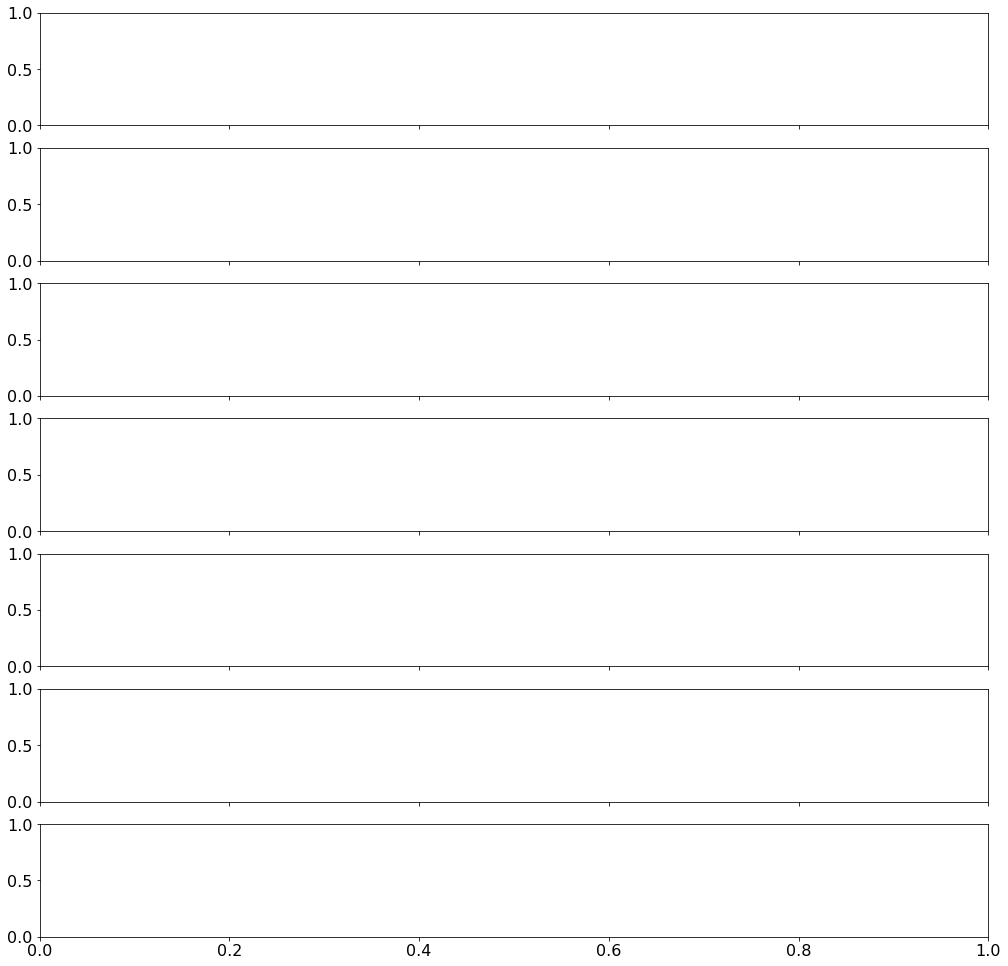

In [110]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [113]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

IndexError: ignored